# AdaBoost with Keras used in a Custom Sklearn Classifier
This is a dummy example of using sklearn's adaboost metaclassifier with a custom sklearn classifier, that contains a keras model.

## Imports

In [ ]:
import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import numpy as np
import math

## Test- and Training Dataset

In [ ]:
X_all, y_all = make_classification(n_samples=1000, n_features=50,
                           n_informative=10, n_redundant=0,
                           random_state=0, shuffle=False, class_sep=0.2)

X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=42)

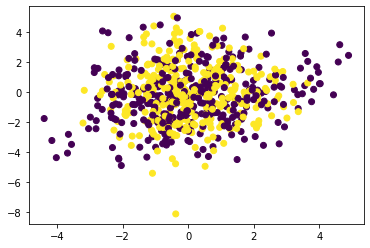

In [ ]:
plt.scatter(X[:,0], X[:,1], c=y)

## Create a simple Keras Model

In [ ]:
def simple_model():                                           
    # create model
    model = Sequential()
    model.add(Dense(25, input_dim=50, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model

## Train and evaluate a single Keras Model

In [ ]:
model = simple_model()
model.fit(X, y, batch_size=32, epochs=10)
model.evaluate(X_test, y_test)

Epoch 1/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2970 - accuracy: 0.5209
Epoch 2/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2783 - accuracy: 0.5463
Epoch 3/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2629 - accuracy: 0.5836
Epoch 4/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2500 - accuracy: 0.6104
Epoch 5/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2383 - accuracy: 0.6269
Epoch 6/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2273 - accuracy: 0.6448
Epoch 7/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2181 - accuracy: 0.6597
Epoch 8/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2095 - accuracy: 0.6866
Epoch 9/10
21/21 [==============================] - 0s 1ms/step - loss: 0.2020 - accuracy: 0.7000
Epoch 10/10
11/11 [==============================] - 0s 1ms/step - loss: 0.2651 - accuracy: 0.5303


[0.2650579512119293, 0.5303030014038086]

## Subclass the KerasClassifier-Wrapper and make it Boosting-Ready
This mainly stolen from this [pull request](https://github.com/keras-team/keras/pull/9252).

In [ ]:
class MyKerasClassifier(KerasClassifier):
  def fit(self, x, y, sample_weight=None, **kwargs):
    """Constructs a new model with `build_fn` & fit the model to `(x, y)`.
    # Arguments
        x : array-like, shape `(n_samples, n_features)`
            Training samples where `n_samples` is the number of samples
            and `n_features` is the number of features.
        y : array-like, shape `(n_samples,)` or `(n_samples, n_outputs)`
            True labels for `x`.
        **kwargs: dictionary arguments
            Legal arguments are the arguments of `Sequential.fit`
    # Returns
        history : object
            details about the training history at each epoch.
    # Raises
        ValueError: In case of invalid shape for `y` argument.
    """
    y = np.array(y)
    if len(y.shape) == 2 and y.shape[1] > 1:
        self.classes_ = np.arange(y.shape[1])
    elif (len(y.shape) == 2 and y.shape[1] == 1) or len(y.shape) == 1:
        self.classes_ = np.unique(y)
        y = np.searchsorted(self.classes_, y)
    else:
        raise ValueError('Invalid shape for y: ' + str(y.shape))
    self.n_classes_ = len(self.classes_)
    if sample_weight is not None:
        kwargs['sample_weight'] = sample_weight
    return super(MyKerasClassifier, self).fit(x, y, **kwargs)
    #return super(KerasClassifier, self).fit(x, y, sample_weight=sample_weight)

  def predict(self, x, **kwargs):
    """Returns the class predictions for the given test data.
    # Arguments
        x: array-like, shape `(n_samples, n_features)`
            Test samples where `n_samples` is the number of samples
            and `n_features` is the number of features.
        **kwargs: dictionary arguments
            Legal arguments are the arguments
            of `Sequential.predict_classes`.
    # Returns
        preds: array-like, shape `(n_samples,)`
            Class predictions.
    """
    kwargs = self.filter_sk_params(Sequential.predict_classes, kwargs)
    classes = self.model.predict_classes(x, **kwargs)
    return self.classes_[classes].flatten()

## Use the Keras-Wrapper from above to build a Silly Binary Classifier

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
class SillyBinaryClassifier(BaseEstimator, ClassifierMixin):
  def __init__(self):
    self.model = simple_model()
    
    self.classifier = MyKerasClassifier(build_fn=simple_model, epochs=10, batch_size=32, verbose=0)

  def fit(self, X, y, sample_weight=None):
    self.n_classes_ = 2
    self.classes_ = np.array([0, 1])
    self.classifier.fit(X, y, sample_weight)

  def predict(self, X):
    prediction = self.classifier.predict(X)
    return prediction

## Boost the SillyBinaryClassifier using sklearn's AdaBoostClassifier

In [ ]:
boosted_classifier = AdaBoostClassifier(
    base_estimator=SillyBinaryClassifier(),
    n_estimators=10,
    random_state=0,
    algorithm="SAMME")

In [ ]:
boosted_classifier.fit(X,y)

AdaBoostClassifier(algorithm='SAMME', base_estimator=SillyBinaryClassifier(),
                   learning_rate=1.0, n_estimators=10, random_state=0)

In [ ]:
boosted_classifier.score(X_test, y_test)

0.6121212121212121